<a href="https://colab.research.google.com/github/gauravvxv/QuickBite-Express-Crisis-Recovery/blob/main/Notebook/QuickBite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **QuickBite Express Crisis Recovery**


## **Business Problem**

QuickBite Express is a Bengaluru-based food-tech startup (founded in 2020) that connects customers with nearby restaurants and cloud kitchens. In June 2025, QuickBite faced a major crisis. A viral social media incident involving food safety violations at partner restaurants, combined with a week-long delivery outage during the monsoon season, triggered massive customer backlash. Competitors capitalized with aggressive campaigns, worsening the situation.

The challenges were severe:

* A large portion of active users disengaged within a short period.
* Daily orders saw a sharp decline compared to earlier months.
* Customer satisfaction scores fell sharply, signaling trust issues.
* Many partner restaurants shifted to competing platforms.
* Customer acquisition costs rose significantly.

## **Import Libraries**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

## **Load CSV file**

In [63]:
customers = pd.read_csv('/content/drive/MyDrive/RPC_18_Datasets/dim_customer.csv')
d_partner = pd.read_csv('/content/drive/MyDrive/RPC_18_Datasets/dim_delivery_partner_.csv')
menu = pd.read_csv('/content/drive/MyDrive/RPC_18_Datasets/dim_menu_item.csv')
restaurants = pd.read_csv('/content/drive/MyDrive/RPC_18_Datasets/dim_restaurant.csv')
d_performance = pd.read_csv('/content/drive/MyDrive/RPC_18_Datasets/fact_delivery_performance.csv')
order_items = pd.read_csv('/content/drive/MyDrive/RPC_18_Datasets/fact_order_items.csv')
orders = pd.read_csv('/content/drive/MyDrive/RPC_18_Datasets/fact_orders.csv')
rating = pd.read_csv('/content/drive/MyDrive/RPC_18_Datasets/fact_ratings.csv')

## **All DataFrame into one Dictionary**

In [64]:
datasets = {
    'customers': customers,
    'delivery_partner': d_partner,
    'menu': menu,
    'restaurants': restaurants,
    'delivery_performance': d_performance,
    'order_items': order_items,
    'orders': orders,
    'rating': rating
}

In [65]:
summary = []

for name, df in datasets.items():
    row = {
        'Dataset': name,
        'Rows': df.shape[0],
        'Columns': df.shape[1],
        'Total missing values': df.isnull().sum().sum(),
        'Total duplicate rows': df.duplicated().sum()
    }
    summary.append(row)

summary_df = pd.DataFrame(summary)

summary_df

,Dataset,Rows,Columns,Total missing values,Total duplicate rows
0,customers,107776,4,0,0
1,delivery_partner,15000,7,0,0
2,menu,342671,6,0,0
3,restaurants,19995,7,0,0
4,delivery_performance,149166,4,0,0
5,order_items,342994,8,0,0
6,orders,149166,11,5635,0
7,rating,68842,7,119,16


In [66]:
for name, df in datasets.items():
    print(f"Null values in dataset: {name}")
    null_counts = df.isnull().sum()
    null_cols = null_counts[null_counts > 0]

    if null_cols.empty:
        print("No null values found.")
    else:
        print(null_cols)

    print("\n")

Null values in dataset: customers
No null values found.


Null values in dataset: delivery_partner
No null values found.


Null values in dataset: menu
No null values found.


Null values in dataset: restaurants
No null values found.


Null values in dataset: delivery_performance
No null values found.


Null values in dataset: order_items
No null values found.


Null values in dataset: orders
delivery_partner_id    5635
dtype: int64


Null values in dataset: rating
order_id            17
customer_id         17
restaurant_id       17
rating              17
review_text         17
review_timestamp    17
sentiment_score     17
dtype: int64




In [67]:
rating.dropna(inplace=True)

## **Convert Date**

In [71]:
orders['order_timestamp'] = pd.to_datetime(orders['order_timestamp'])
rating['review_timestamp'] = pd.to_datetime(
    rating['review_timestamp'],
    format="%d-%m-%Y %H:%M",
    errors='coerce'
)
customers['signup_date'] = pd.to_datetime(customers['signup_date'])

/tmp/ipython-input-2016481858.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  customers['signup_date'] = pd.to_datetime(customers['signup_date'])


## **Feature Engineering**

In [15]:
orders['order_month'] = pd.to_datetime(orders['order_timestamp']).dt.month

In [16]:
orders['crisis_phase']  = orders['order_timestamp'].apply(lambda x: 'Pre-Crisis' if x < '2025-06-01' else 'Crisis' if x <= '2025-06-30' else 'Recovery')

## **Exploratory Data Analysis (EDA)**

In [17]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107776 entries, 0 to 107775
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   customer_id          107776 non-null  object
 1   signup_date          107776 non-null  object
 2   city                 107776 non-null  object
 3   acquisition_channel  107776 non-null  object
dtypes: object(4)
memory usage: 3.3+ MB


In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149166 entries, 0 to 149165
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             149166 non-null  object 
 1   customer_id          149166 non-null  object 
 2   restaurant_id        149166 non-null  object 
 3   delivery_partner_id  143531 non-null  object 
 4   order_timestamp      149166 non-null  object 
 5   subtotal_amount      149166 non-null  float64
 6   discount_amount      149166 non-null  float64
 7   delivery_fee         149166 non-null  float64
 8   total_amount         149166 non-null  float64
 9   is_cod               149166 non-null  object 
 10  is_cancelled         149166 non-null  object 
 11  order_month          149166 non-null  int32  
 12  crisis_phase         149166 non-null  object 
dtypes: float64(4), int32(1), object(8)
memory usage: 14.2+ MB


In [19]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342994 entries, 0 to 342993
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       342994 non-null  object 
 1   item_id        342994 non-null  object 
 2   menu_item_id   342994 non-null  object 
 3   restaurant_id  342994 non-null  object 
 4   quantity       342994 non-null  int64  
 5   unit_price     342994 non-null  float64
 6   item_discount  342994 non-null  float64
 7   line_total     342994 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 20.9+ MB


In [20]:
d_partner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   delivery_partner_id  15000 non-null  object 
 1   partner_name         15000 non-null  object 
 2   city                 15000 non-null  object 
 3   vehicle_type         15000 non-null  object 
 4   employment_type      15000 non-null  object 
 5   avg_rating           15000 non-null  float64
 6   is_active            15000 non-null  object 
dtypes: float64(1), object(6)
memory usage: 820.4+ KB


In [21]:
menu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342671 entries, 0 to 342670
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   menu_item_id   342671 non-null  object 
 1   restaurant_id  342671 non-null  object 
 2   item_name      342671 non-null  object 
 3   category       342671 non-null  object 
 4   is_veg         342671 non-null  object 
 5   price          342671 non-null  float64
dtypes: float64(1), object(5)
memory usage: 15.7+ MB


In [22]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   restaurant_id      19995 non-null  object
 1   restaurant_name    19995 non-null  object
 2   city               19995 non-null  object
 3   cuisine_type       19995 non-null  object
 4   partner_type       19995 non-null  object
 5   avg_prep_time_min  19995 non-null  object
 6   is_active          19995 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [23]:
d_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149166 entries, 0 to 149165
Data columns (total 4 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     149166 non-null  object 
 1   actual_delivery_time_mins    149166 non-null  int64  
 2   expected_delivery_time_mins  149166 non-null  int64  
 3   distance_km                  149166 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.6+ MB


In [24]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68825 entries, 0 to 68829
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          68825 non-null  object 
 1   customer_id       68825 non-null  object 
 2   restaurant_id     68825 non-null  object 
 3   rating            68825 non-null  float64
 4   review_text       68825 non-null  object 
 5   review_timestamp  68825 non-null  object 
 6   sentiment_score   68825 non-null  float64
dtypes: float64(2), object(5)
memory usage: 4.2+ MB


In [25]:
orders.describe()

,subtotal_amount,discount_amount,delivery_fee,total_amount,order_month
count,149166.000000,149166.000000,149166.000000,149166.000000,149166.000000
mean,314.373203,18.891589,30.069224,325.550833,4.039064
std,147.346779,29.801279,10.997816,146.790190,2.343466
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,234.960000,0.000000,24.730000,249.842500,2.000000
50%,309.070000,0.000000,31.485000,321.700000,4.000000
75%,396.290000,34.690000,38.240000,406.590000,5.000000
max,900.000000,222.530000,45.000000,944.910000,9.000000


In [26]:
d_performance.describe()

,actual_delivery_time_mins,expected_delivery_time_mins,distance_km
count,149166.000000,149166.000000,149166.000000
mean,44.404549,38.691679,4.494667
std,12.784224,5.074100,2.021213
min,25.000000,30.000000,1.000000
25%,36.000000,35.000000,2.700000
50%,42.000000,39.000000,4.500000
75%,50.000000,43.000000,6.200000
max,90.000000,50.000000,8.000000


In [42]:
order_trend = orders.groupby('order_month')['order_id'].count().reset_index()
order_trend

,order_month,order_id
0,1,23539
1,2,22667
2,3,23543
3,4,21466
4,5,22591
5,6,9293
6,7,8818
7,8,8555
8,9,8694


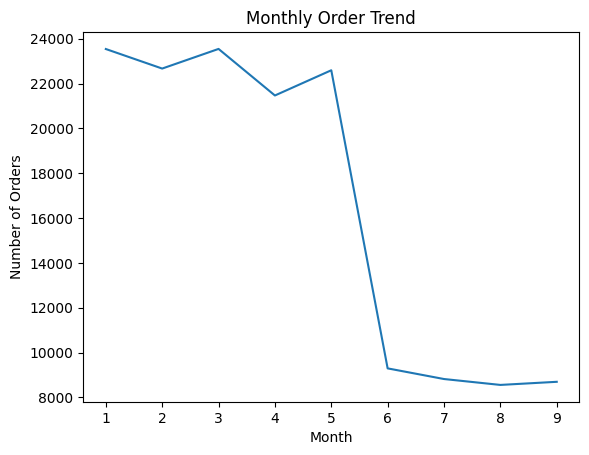

In [30]:
sns.lineplot(x='order_month', y='order_id', data=order_trend)
plt.title('Monthly Order Trend')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()

In [82]:
orders.to_csv("fact_orders_clean.csv", index=False)
rating.to_csv("fact_ratings_clean.csv", index=False)
customers.to_csv("dim_customer_clean.csv", index=False)
d_performance.to_csv("fact_delivery_clean.csv", index=False)
restaurants.to_csv("dim_restaurant_clean.csv", index=False)
menu.to_csv("dim_menu_item_clean.csv", index=False)
d_partner.to_csv("dim_delivery_partner_clean.csv", index=False)


In [86]:
order_items.to_csv("order_items_clean.csv",index=False)